In [1]:
# Introduction

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import signal

from sklearn.model_selection import train_test_split

## Download the data
http://mindbigdata.com/opendb/index.html

In [3]:
# %%bash
# #Uncomment to download the data
# wget -q http://mindbigdata.com/opendb/MindBigData-IN-v1.06.zip
# mkdir -p DATA
# unzip -qq MindBigData-IN-v1.06.zip
# mv IN.txt DATA/
# rm MindBigData-IN-v1.06.zip

In [4]:
# Load and clean data

In [5]:
PATH_DATA="DATA/IN.txt"

with open(PATH_DATA,'r') as f:
    print(f.readline())

1142043	173652	IN	AF3	0	256	4259.487179,4237.948717,4247.179487,4242.051282,4233.333333,4251.282051,4232.820512,4234.358974,4224.615384,4219.487179,4249.743589,4238.461538,4245.641025,4244.615384,4223.076923,4240.512820,4234.358974,4240.512820,4235.384615,4224.102564,4255.384615,4243.589743,4243.589743,4248.205128,4226.666666,4244.102564,4228.717948,4225.641025,4236.923076,4208.717948,4226.153846,4234.871794,4234.871794,4245.641025,4233.846153,4263.076923,4261.025641,4244.615384,4261.025641,4242.051282,4243.589743,4233.333333,4221.025641,4241.538461,4235.384615,4250.256410,4235.897435,4221.538461,4268.717948,4257.435897,4238.974358,4232.307692,4218.461538,4244.615384,4236.410256,4235.384615,4246.666666,4238.461538,4252.820512,4234.358974,4232.820512,4247.692307,4234.871794,4260.000000,4249.230769,4233.846153,4251.282051,4249.230769,4272.820512,4265.128205,4256.410256,4265.641025,4233.333333,4253.846153,4256.923076,4238.461538,4265.641025,4256.923076,4254.871794,4251.794871,4244.615384,

In [6]:
df=pd.read_csv(PATH_DATA,delimiter="\t",header=None,names=["id","event","device","channel","code","size","data"])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65250 entries, 0 to 65249
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       65250 non-null  int64 
 1   event    65250 non-null  int64 
 2   device   65250 non-null  object
 3   channel  65250 non-null  object
 4   code     65250 non-null  int64 
 5   size     65250 non-null  int64 
 6   data     65250 non-null  object
dtypes: int64(4), object(3)
memory usage: 3.5+ MB
None


,id,event,device,channel,code,size,data
0,1142043,173652,IN,AF3,0,256,"4259.487179,4237.948717,4247.179487,4242.05128..."
1,1142044,173652,IN,AF4,0,256,"4103.076923,4100.512820,4102.564102,4087.69230..."
2,1142045,173652,IN,T7,0,256,"4245.128205,4218.461538,4242.051282,4245.12820..."
3,1142046,173652,IN,T8,0,256,"4208.717948,4188.717948,4204.102564,4198.46153..."
4,1142047,173652,IN,PZ,0,256,"4189.230769,4203.589743,4188.717948,4186.66666..."


In [7]:
df.id.nunique()

65250

In [8]:
df.event.nunique()

13050

In [9]:
df.channel.nunique()

5

<AxesSubplot:>

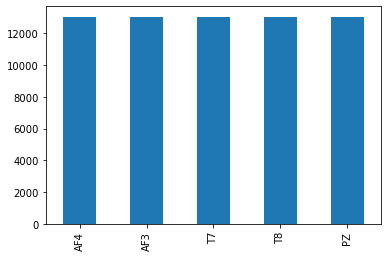

In [10]:
df.channel.value_counts().plot.bar()

In [11]:
df.code.nunique()

10

<AxesSubplot:>

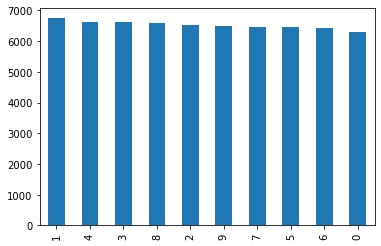

In [12]:
df.code.value_counts().plot.bar()

In [13]:
df["size"].mean()

244.13532567049808

In [14]:
df["size"].std()

31.935014214264896

### Dealing with the data values

In [15]:
df.data=df.data.apply(lambda x: [float(i) for i in x.split(",")])

In [16]:
df.data.apply(np.mean).agg(["mean","std"])

mean    4276.380742
std       37.388607
Name: data, dtype: float64

In [17]:
df.data.apply(np.std).agg(["mean","std"])

mean    19.463488
std     24.060789
Name: data, dtype: float64

In [18]:
event_id=173652
df.query(f"event=={event_id}")

,id,event,device,channel,code,size,data
0,1142043,173652,IN,AF3,0,256,"[4259.487179, 4237.948717, 4247.179487, 4242.0..."
1,1142044,173652,IN,AF4,0,256,"[4103.076923, 4100.51282, 4102.564102, 4087.69..."
2,1142045,173652,IN,T7,0,256,"[4245.128205, 4218.461538, 4242.051282, 4245.1..."
3,1142046,173652,IN,T8,0,256,"[4208.717948, 4188.717948, 4204.102564, 4198.4..."
4,1142047,173652,IN,PZ,0,256,"[4189.230769, 4203.589743, 4188.717948, 4186.6..."


In [19]:
# generate times column
df["time"]=df.apply(lambda row: list(np.arange(0,2,1/row.size)),axis=1)

In [20]:
def plot_event(event_id):
    df_aux=df.query(f"event=={event_id}")
    df_plot=pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"])))
    plt.figure(figsize=(10,10))
    sns.lineplot(data=df_plot)
    plt.title(f"Event: {df_aux.iloc[0].event} - Digit: {df_aux.iloc[0].code}")

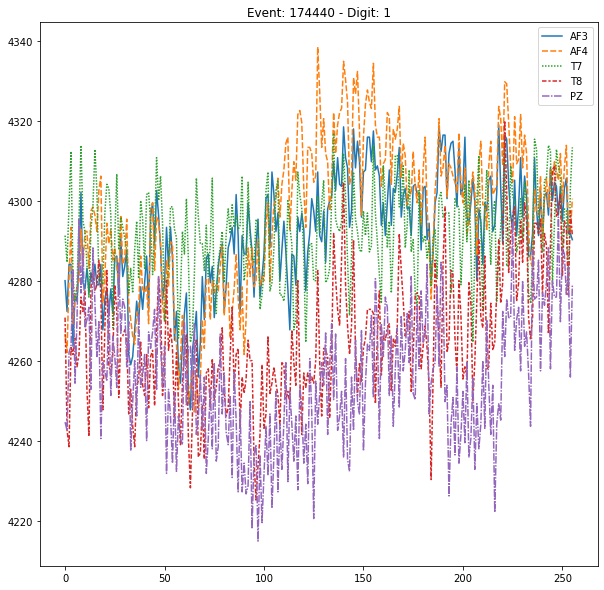

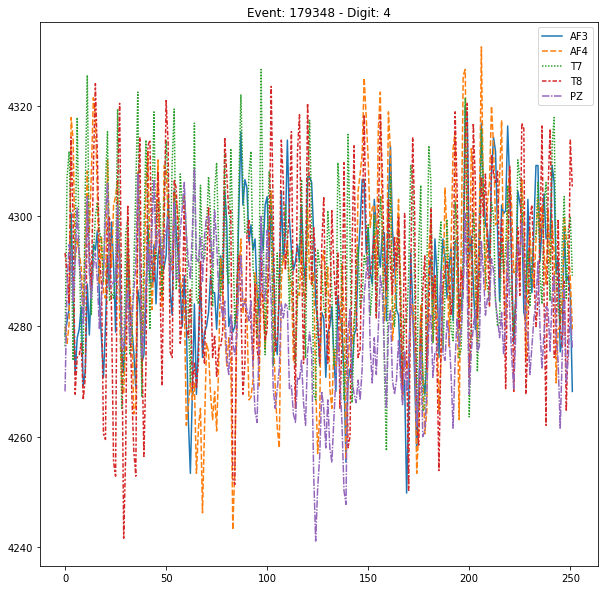

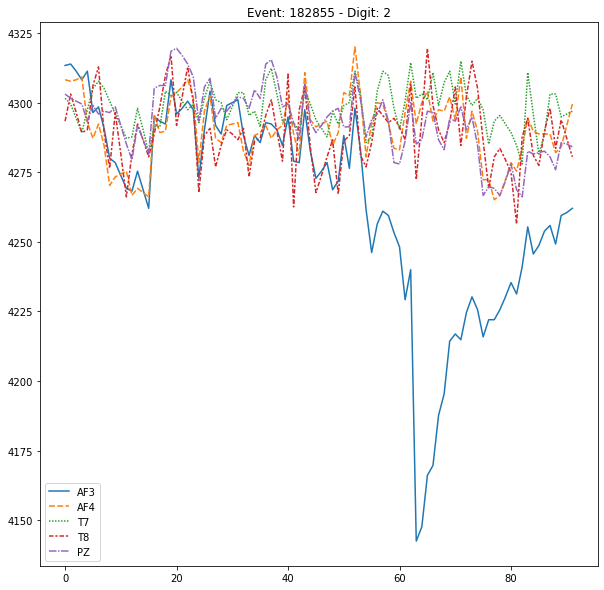

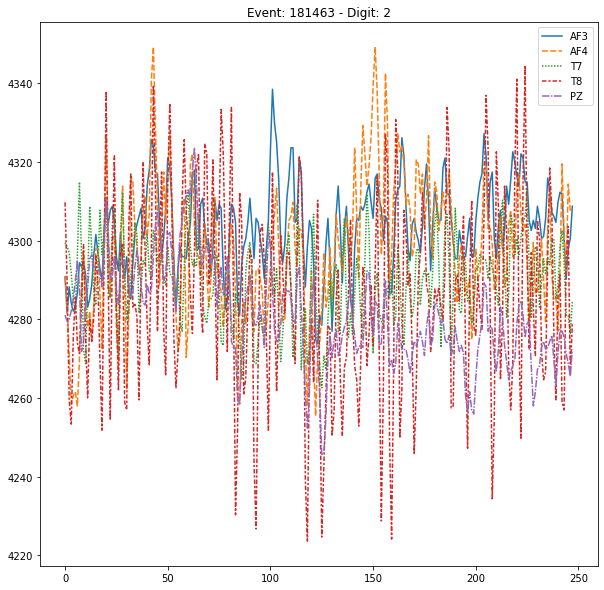

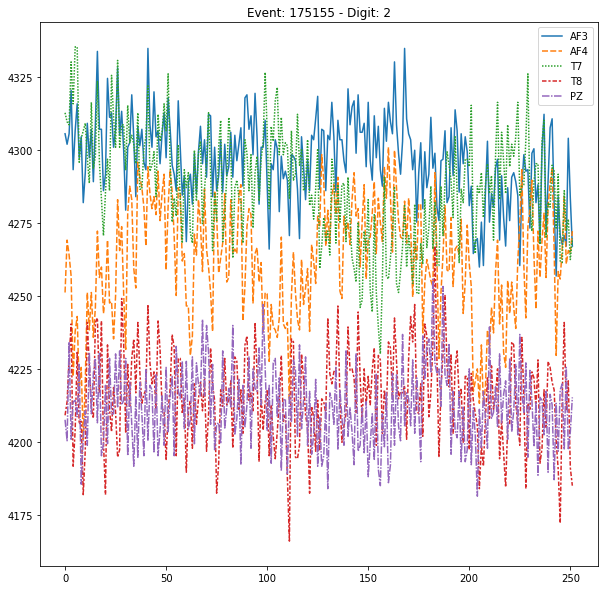

In [21]:
for ev_id in random.sample(df.event.unique().tolist(),5):
    plot_event(ev_id)

## Modeling

In [22]:
def get_sample(event_id):
    df_aux=df.query(f"event=={event_id}")
    return pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"]))).values.T.reshape(1,5,-1)

In [23]:
get_sample(event_id).shape

(1, 5, 256)

In [24]:
def get_values_df(df_aux,resample_value=272):
    df_aux=df_aux.sort_values(by="channel")
    channels_values=pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"]))).values.T.reshape(5,-1)
    channels_values=signal.resample(channels_values,272,axis=1)
    label=df_aux.code.iloc[0]
    return pd.Series({'eeg': channels_values, 'label': label}) #https://stackoverflow.com/questions/10751127/returning-multiple-values-from-pandas-apply-on-a-dataframe


In [25]:
df.head()

,id,event,device,channel,code,size,data,time
0,1142043,173652,IN,AF3,0,256,"[4259.487179, 4237.948717, 4247.179487, 4242.0...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
1,1142044,173652,IN,AF4,0,256,"[4103.076923, 4100.51282, 4102.564102, 4087.69...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
2,1142045,173652,IN,T7,0,256,"[4245.128205, 4218.461538, 4242.051282, 4245.1...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
3,1142046,173652,IN,T8,0,256,"[4208.717948, 4188.717948, 4204.102564, 4198.4...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
4,1142047,173652,IN,PZ,0,256,"[4189.230769, 4203.589743, 4188.717948, 4186.6...","[0.0, 0.14285714285714285, 0.2857142857142857,..."


In [26]:
df_preprocessed=df.groupby(['event']).apply(lambda row: get_values_df(row)).reset_index()

In [27]:
## Train test split
ids_train, ids_test, y_train, y_test=train_test_split(df_preprocessed.index,df_preprocessed.label,test_size=0.2,random_state=11)

In [28]:
y_train.value_counts()/sum(y_train.value_counts())

1    0.104215
4    0.102299
8    0.101341
7    0.101149
3    0.100575
2    0.099617
9    0.099617
5    0.098755
6    0.097510
0    0.094923
Name: label, dtype: float64

In [29]:
y_test.value_counts()/sum(y_test.value_counts())

3    0.103831
0    0.103448
6    0.102299
2    0.102299
5    0.100000
9    0.099617
1    0.099617
8    0.099617
4    0.098084
7    0.091188
Name: label, dtype: float64

In [30]:
df_train=df_preprocessed.loc[ids_train].reset_index(drop=True)
df_test=df_preprocessed.loc[ids_test].reset_index(drop=True)

In [31]:
## Normalize data
NORMALIZE=True
if NORMALIZE:
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    scaler = scaler.fit(np.concatenate(df_train.eeg.values, axis=0))

    df_train.eeg=df_train.eeg.apply(scaler.transform)
    df_test.eeg=df_test.eeg.apply(scaler.transform)

In [32]:
df_test.head()

,event,eeg,label
0,179167,"[[0.4588134844770449, 0.6617663314075795, 0.66...",9
1,174158,"[[0.2660241060743872, 0.6135065348320003, -0.0...",9
2,175959,"[[0.6087607996756665, 0.6936854341801755, 0.65...",3
3,180430,"[[0.1589188958506019, 0.08730334704609458, 0.0...",5
4,176990,"[[0.12678734322638388, -0.038194638549380655, ...",2


In [33]:
print(df_train.shape)
print(df_test.shape)

(10440, 3)
(2610, 3)


## Dataset class and dataloaders

In [34]:
from torch.utils.data import Dataset, DataLoader
import torch

class BrainMNISTDataset(Dataset):
    """Brain MNIST dataset."""

    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame with data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.eeg_frame = df
        self.transform = transform

    def __len__(self):
        return len(self.eeg_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #sample = {'eeg': self.eeg_frame.loc[idx].eeg, 'label': self.eeg_frame.loc[idx].label}
        sample = self.eeg_frame.loc[idx].eeg, self.eeg_frame.loc[idx].label

        if self.transform:
            sample = self.transform(sample)

        return sample

In [35]:
eeg_dataset = BrainMNISTDataset(df=df_train)

for i in range(len(eeg_dataset)):
    sample = eeg_dataset[i]
    print(sample)
    if i>3: break


(array([[ 1.96821121e-02,  1.14592452e-01,  2.56013658e-02, ...,
         6.46012749e-02,  3.32890881e-01,  5.34322917e-01],
       [ 9.46557697e-02, -9.68372131e-02, -2.02163893e-01, ...,
        -1.02338107e-01,  4.35160154e-01,  9.12922897e-01],
       [-1.40975693e-01, -1.41857246e-02, -4.30964292e-04, ...,
        -1.04927171e-01,  1.89186886e-01,  2.56584231e-01],
       [ 3.19576722e-01,  4.59552017e-01,  3.26204868e-01, ...,
        -8.84936672e-02,  1.65545732e-01,  1.98273636e-01],
       [ 2.01760980e-01, -2.46484598e-01, -7.29014612e-01, ...,
         6.61270806e-01,  2.64873081e-01,  3.35837215e-01]]), 4)
(array([[-9.76396353e-01, -7.67268749e-01, -8.69937310e-01, ...,
         3.84267180e-01,  6.39276282e-01,  2.36915569e-01],
       [-1.11563314e+00, -9.30957602e-01, -1.03226388e+00, ...,
         2.59471070e-01,  7.01589216e-01,  3.91251947e-01],
       [-1.39410668e+00, -1.11519553e+00, -1.21222988e+00, ...,
        -1.46317488e-01,  1.38686570e-01, -2.28398570e-01],
 

In [36]:
dataloader = DataLoader(eeg_dataset, batch_size=32, shuffle=True, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched[0].size(),
          sample_batched[1].size())
    if i_batch > 10: break

0 torch.Size([32, 5, 272]) torch.Size([32])
1 torch.Size([32, 5, 272]) torch.Size([32])
2 torch.Size([32, 5, 272]) torch.Size([32])
3 torch.Size([32, 5, 272]) torch.Size([32])
4 torch.Size([32, 5, 272]) torch.Size([32])
5 torch.Size([32, 5, 272]) torch.Size([32])
6 torch.Size([32, 5, 272]) torch.Size([32])
7 torch.Size([32, 5, 272]) torch.Size([32])
8 torch.Size([32, 5, 272]) torch.Size([32])
9 torch.Size([32, 5, 272]) torch.Size([32])
10 torch.Size([32, 5, 272]) torch.Size([32])
11 torch.Size([32, 5, 272]) torch.Size([32])


In [37]:
## Train and test dataloaders
trainloader = DataLoader(BrainMNISTDataset(df=df_train), batch_size=32, shuffle=True, num_workers=0)
evalloader = DataLoader(BrainMNISTDataset(df=df_test), batch_size=32, shuffle=False, num_workers=0)

In [74]:
import torch.nn as nn

# https://rosenfelder.ai/multi-input-neural-network-pytorch/
# https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html

#X = get_sample(event_id)
#print(f"Shape of input values: {X.shape}")

class network(nn.Module):
    def __init__(self, input_channels, output_units):
        super(network, self).__init__()
        self.layer1 = nn.Conv1d(in_channels=input_channels, out_channels=20, kernel_size=5, stride=2)
        self.act1 = nn.ReLU()
        self.avpool = nn.AvgPool1d(32, stride=2)
        #self.layer2 = nn.Conv1d(in_channels=20, out_channels=10, kernel_size=1)
        #self.act2 = nn.ReLU()
        self.out = nn.Linear(1040, output_units)
    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.avpool(x)
        #x = self.layer2(x)
        #x = self.act2(x)
        x = torch.flatten(x, 1)
        x = self.out(x)

        log_probs = torch.nn.functional.log_softmax(x, dim=1)

        return log_probs

    
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier.
    From: https://www.kaggle.com/purplejester/a-simple-lstm-based-time-series-classifier
    """
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.double() for t in (h0, c0)]
    
#model = network(input_channels=5,output_units=10).double()

input_dim = 272    
hidden_dim = 256
layer_dim = 3
output_dim = 10
model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim).double()


#print(model(torch.tensor(X)).shape)

In [75]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [76]:
# Usinng pytorch ignite: https://labs.quansight.org/blog/2020/09/pytorch-ignite/
from ignite.engine import Engine

def train_step(engine, batch):
    x, y = batch
    x = x.to("cpu")
    y = y.to("cpu")

    model.train()
    y_pred = model(x)
    loss = criterion(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

# Define a trainer engine
trainer = Engine(train_step)


def validation_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch[0], batch[1]
        x = x.to("cpu")
        y = y.to("cpu")

        y_pred = model(x)

        return y_pred, y

evaluator = Engine(validation_step)

In [77]:
from ignite.engine import Events

# Show a message when the training begins
@trainer.on(Events.STARTED)
def start_message():
    print("Start training!")

# Handler can be want you want, here a lambda ! 
trainer.add_event_handler(
    Events.COMPLETED, 
    lambda _: print("Training completed!")
)

# Run evaluator on val_loader every trainer's epoch completed
@trainer.on(Events.EPOCH_COMPLETED)
def run_validation():
    evaluator.run(evalloader)

In [78]:
from ignite.metrics import Accuracy, Loss

# Accuracy and loss metrics are defined
val_metrics = {
  "accuracy": Accuracy(),
  "loss": Loss(criterion)
}

# Attach metrics to the evaluator
for name, metric in val_metrics.items():
    metric.attach(evaluator, name)

In [79]:
from ignite.metrics import Precision, Recall

# Build F1 score
precision = Precision(average=False)
recall = Recall(average=False)
F1 = (precision * recall * 2 / (precision + recall)).mean()

# and attach it to evaluator
F1.attach(evaluator, "f1")

In [80]:
from ignite.engine import create_supervised_evaluator

# Define another evaluator with default validation function and attach metrics
train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device="cpu")

# Run train_evaluator on train_loader every trainer's epoch completed
@trainer.on(Events.EPOCH_COMPLETED)
def run_train_validation():
    train_evaluator.run(evalloader)

In [81]:
@evaluator.on(Events.COMPLETED)
def log_validation_results():
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f} Avg F1: {:.2f}"
          .format(trainer.state.epoch, metrics["accuracy"], metrics["loss"], metrics["f1"]))
    
@train_evaluator.on(Events.COMPLETED)
def log_train_results():
    metrics = train_evaluator.state.metrics
    print("  Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics["accuracy"], metrics["loss"]))

In [82]:
from ignite.contrib.handlers import ProgressBar

ProgressBar().attach(trainer, output_transform=lambda x: {'batch loss': x})

In [83]:
from ignite.handlers import ModelCheckpoint, global_step_from_engine

# Score function to select relevant metric, here f1
def score_function(engine):
    return engine.state.metrics["f1"]

# Checkpoint to store n_saved best models wrt score function
model_checkpoint = ModelCheckpoint(
    "brain_mnist_custom",
    n_saved=2,
    filename_prefix="best",
    score_function=score_function,
    score_name="f1",
    global_step_transform=global_step_from_engine(trainer),
)
  
# Save the model (if relevant) every epoch completed of evaluator
evaluator.add_event_handler(Events.COMPLETED, model_checkpoint, {"model": model});

In [84]:
from ignite.contrib.handlers import TensorboardLogger

# Define a Tensorboard logger
tb_logger = TensorboardLogger(log_dir="brain_mnist_logs")

# Attach handler to plot trainer's loss every 100 iterations
tb_logger.attach_output_handler(
    trainer,
    event_name=Events.ITERATION_COMPLETED(every=100),
    tag="training",
    output_transform=lambda loss: {"batchloss": loss},
)

# Attach handler to dump evaluator's metrics every epoch completed
for tag, evaluator in [("training", train_evaluator), ("validation", evaluator)]:
    tb_logger.attach_output_handler(
        evaluator,
        event_name=Events.EPOCH_COMPLETED,
        tag=tag,
        metric_names="all",
        global_step_transform=global_step_from_engine(trainer),
    )

In [ ]:
trainer.run(trainloader, max_epochs=50)

# Once everything is done, let's close the logger
tb_logger.close()

Start training!


/opt/conda/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Validation Results - Epoch: 1  Avg accuracy: 0.09 Avg loss: 2.30 Avg F1: nan
  Training Results - Epoch: 1  Avg accuracy: 0.09 Avg loss: 2.30


Validation Results - Epoch: 2  Avg accuracy: 0.09 Avg loss: 2.30 Avg F1: nan
  Training Results - Epoch: 2  Avg accuracy: 0.09 Avg loss: 2.30


Validation Results - Epoch: 3  Avg accuracy: 0.10 Avg loss: 2.30 Avg F1: nan
  Training Results - Epoch: 3  Avg accuracy: 0.10 Avg loss: 2.30


Validation Results - Epoch: 4  Avg accuracy: 0.10 Avg loss: 2.30 Avg F1: nan
  Training Results - Epoch: 4  Avg accuracy: 0.10 Avg loss: 2.30


Validation Results - Epoch: 5  Avg accuracy: 0.10 Avg loss: 2.30 Avg F1: nan
  Training Results - Epoch: 5  Avg accuracy: 0.10 Avg loss: 2.30


Validation Results - Epoch: 6  Avg accuracy: 0.10 Avg loss: 2.30 Avg F1: nan
  Training Results - Epoch: 6  Avg accuracy: 0.10 Avg loss: 2.30


Validation Results - Epoch: 7  Avg accuracy: 0.10 Avg loss: 2.30 Avg F1: nan
  Training Results - Epoch: 7  Avg accuracy: 0.10 Avg loss: 2.30


Validation Results - Epoch: 8  Avg accuracy: 0.10 Avg loss: 2.30 Avg F1: nan
  Training Results - Epoch: 8  Avg accuracy: 0.10 Avg loss: 2.30


Validation Results - Epoch: 9  Avg accuracy: 0.10 Avg loss: 2.30 Avg F1: nan
  Training Results - Epoch: 9  Avg accuracy: 0.10 Avg loss: 2.30


Validation Results - Epoch: 10  Avg accuracy: 0.10 Avg loss: 2.30 Avg F1: nan
  Training Results - Epoch: 10  Avg accuracy: 0.10 Avg loss: 2.30


Validation Results - Epoch: 11  Avg accuracy: 0.10 Avg loss: 2.30 Avg F1: nan
  Training Results - Epoch: 11  Avg accuracy: 0.10 Avg loss: 2.30


In [ ]:
# Training loop

# NUM_EPOCHS=1000

# for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, sample_batched in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = sample_batched['eeg'],sample_batched['label']

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 400 == 399:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0
        
 
#     # Validation loss
#     val_loss = 0.0
#     val_steps = 0
#     total = 0
#     correct = 0
#     for i, sample_batched in enumerate(testloader, 0):
#         with torch.no_grad():
#             inputs, labels = sample_batched['eeg'],sample_batched['label']
#             #inputs, labels = inputs.to(device), labels.to(device)

#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             loss = criterion(outputs, labels)
#             val_loss += loss.cpu().numpy()
#             val_steps += 1
            
#     print('[%d] val loss: %.3f val acc; %.3f' %
#                   (epoch + 1, val_loss / 2000, correct/total))

# print('Finished Training')